In [20]:
import parcels
import xarray as xr
from datetime import timedelta, datetime
import os
import json

import random
import numpy as np
import time

import matplotlib.pyplot as plt
import pandas as pd

In [21]:
mitgcm_results_path_arr = ['/storage/alplakes_test/ARTFUL_project/01_2023-09-12/geneva_artful_01.nc',
                           '/storage/alplakes_test/ARTFUL_project/02_2023-11-08/geneva_artful_02.nc',
                           '/storage/alplakes_test/ARTFUL_project/03_2024-05-01/geneva_artful_03.nc',
                           '/storage/alplakes_test/geneva_madeline_forecast/crop_results/geneva_100m_2026_forecast.nc']

date_end_seeding_arr = [np.datetime64('2023-09-12 12:00:00'), #UTC
                        np.datetime64('2023-11-08 11:00:00'), #UTC
                        np.datetime64('2024-05-01 12:00:00'), #UTC
                        np.datetime64('2026-01-27 09:00:00')] #local

depth_arr = [(24,26),
             (1,26),
             (1,3),
             (0.5,2)]

suffix_output = 'jan2026_forecast_r50m'
output_file_path_arr = [f"02_output/artful_01_{suffix_output}.zarr",
                        f"02_output/artful_02_{suffix_output}.zarr",
                        f"02_output/artful_03_{suffix_output}.zarr",
                        f"02_output/{suffix_output}.zarr"]

### Parameters

In [22]:
i_scenario = 3
mitgcm_results_path = mitgcm_results_path_arr[i_scenario]
date_end_seeding = date_end_seeding_arr[i_scenario]

output_file_path = output_file_path_arr[i_scenario]

period_seeding = np.timedelta64(0, 'D')
freq_seeding = np.timedelta64(1, 'h')

date_start_seeding = date_end_seeding - period_seeding

In [23]:
date_start_seeding

np.datetime64('2026-01-27T09:00:00')

In [24]:
Cs = 0.2

n_part_per_seeding = 10000
depth_min = depth_arr[i_scenario][0] # minimum release depth
depth_max = depth_arr[i_scenario][1] # maximum release depth

(x_c,y_c) = (44275, 21375) # center of seeding point in MITgcm coordinates
r_seeding = 50 # the radius around the center in m

## Create velocity fields from MITgcm

In [25]:
xr_mitgcm = xr.open_dataset(mitgcm_results_path)
date_ref = xr_mitgcm.time.values[0]

In [26]:
xr_mitgcm.Z.values

array([-2.500000e-01, -7.575000e-01, -1.280500e+00, -1.820000e+00,
       -2.376000e+00, -2.949000e+00, -3.540000e+00, -4.149000e+00,
       -4.776500e+00, -5.423500e+00, -6.090500e+00, -6.778000e+00,
       -7.486500e+00, -8.216500e+00, -8.969000e+00, -9.745000e+00,
       -1.054500e+01, -1.136950e+01, -1.221950e+01, -1.309550e+01,
       -1.399850e+01, -1.492950e+01, -1.588900e+01, -1.687800e+01,
       -1.789750e+01, -1.894800e+01, -2.003050e+01, -2.114650e+01,
       -2.229700e+01, -2.348300e+01, -2.470550e+01, -2.596550e+01,
       -2.726400e+01, -2.860250e+01, -2.998250e+01, -3.140500e+01,
       -3.287100e+01, -3.438200e+01, -3.593950e+01, -3.754500e+01,
       -3.920000e+01, -4.090600e+01, -4.266450e+01, -4.447700e+01,
       -4.634550e+01, -4.827150e+01, -5.025650e+01, -5.230250e+01,
       -5.441150e+01, -5.658550e+01, -5.882650e+01, -6.113650e+01,
       -6.351750e+01, -6.597150e+01, -6.850100e+01, -7.110850e+01,
       -7.379600e+01, -7.656600e+01, -7.942150e+01, -8.236500e

In [27]:
variables = {"U": "UVEL", "V": "VVEL", "W": "WVEL"}
dimensions = {
    "U": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "V": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "W": {
        "lon": "XG",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
}
fieldset = parcels.FieldSet.from_mitgcm(
    filenames=[mitgcm_results_path], 
    variables=variables, 
    dimensions=dimensions, 
    allow_time_extrapolation=False,
    mesh='flat') # mesh='flat' if longitudes and latitudes are given in meters, rather than degrees

In [28]:
x = fieldset.U.grid.lon
y = fieldset.U.grid.lat

cell_areas = parcels.Field(
    name="cell_areas", data=fieldset.U.cell_areas(), lon=x, lat=y
)
fieldset.add_field(cell_areas)

fieldset.add_constant("Cs", Cs)

## Create particle set

Here we create particles randomly seeded within a defined circle.

In [29]:
def RandomPointInCircle(R,xc,yc):
    r = R*random.random()
    theta = 2*np.pi*random.random()
    
    return xc+r*np.cos(theta),yc+r*np.sin(theta)

In [30]:
def RandomPointInRectangle(xmin, xmax, ymin, ymax):
    return xmin+(xmax-xmin)*random.random(), ymin+(ymax-ymin)*random.random()

In [31]:
n_part = int(n_part_per_seeding * (1 + (period_seeding / freq_seeding))) # total number of particles at the end
print('Total number of particles: ' + str(n_part))
print('Date ref: ' + str(date_ref))
print('Date start seeding: ' + str(date_start_seeding))
print('Date end seeding: ' + str(date_start_seeding + int(period_seeding / freq_seeding) * freq_seeding))
print('Depth min: ' + str(depth_min))
print('Depth max: ' + str(depth_max))

zi_particles = np.array([-random.uniform(depth_min, depth_max) for i in range(n_part)])
xi_particles = x_c*np.ones(n_part)
yi_particles = y_c*np.ones(n_part)

timei_particles = np.zeros(n_part)
for i in range(0,int(1+period_seeding / freq_seeding)):
    seeding_date = date_start_seeding + i * freq_seeding
    timei_particles[i * n_part_per_seeding : (i+1) * n_part_per_seeding] = (seeding_date - date_ref)/ np.timedelta64(1, 's')

for i in range(n_part):
    (xd,yd) = RandomPointInCircle(r_seeding,x_c,y_c)
    xi_particles[i] = xd
    yi_particles[i] = yd

Total number of particles: 10000
Date ref: 2026-01-26T01:30:00.000000000
Date start seeding: 2026-01-27T09:00:00
Date end seeding: 2026-01-27T09:00:00
Depth min: 0.5
Depth max: 2


In [32]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=parcels.JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=xi_particles,  # a vector of release longitudes
    lat=yi_particles,  # a vector of release latitudes
    depth=zi_particles,
    time=timei_particles
)

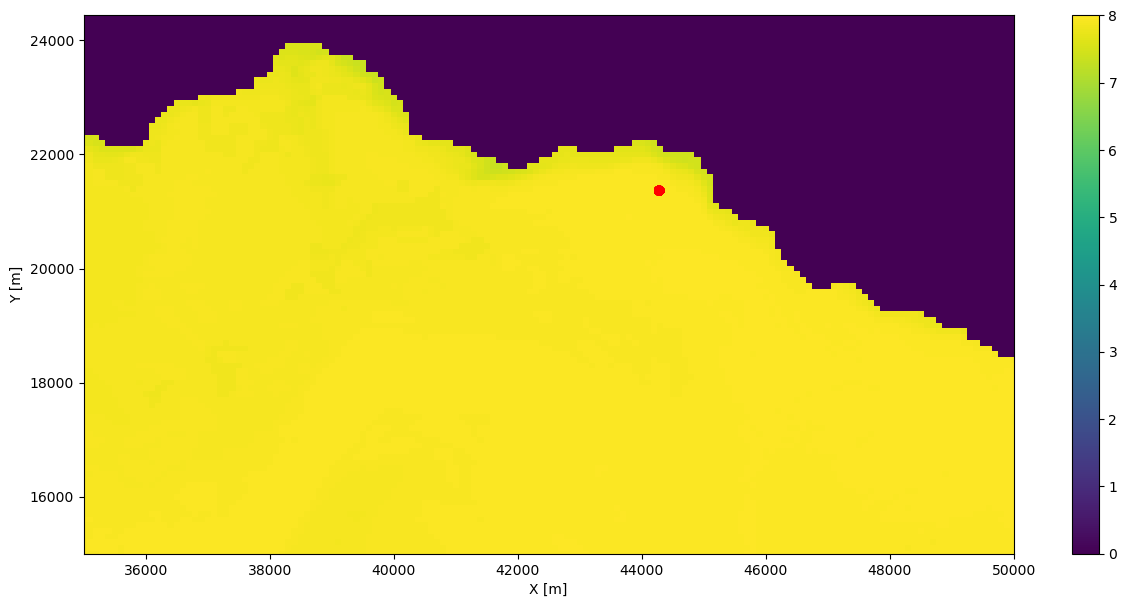

In [33]:
plt.figure(figsize=(15,7))
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, xr_mitgcm['THETA'].isel(Z=0, time= -1).values)
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.colorbar()

plt.scatter(pset.lon[0:n_part_per_seeding], pset.lat[0:n_part_per_seeding], s=3, c='r')
plt.xlim(left=35000, right=50000)
plt.ylim(bottom=15000)
plt.show()

## Create a new kernel for Smagorinsky diffusion method

https://docs.oceanparcels.org/en/latest/examples/tutorial_diffusion.html

In [34]:
def smagdiff(particle, fieldset, time):
    dx = 100
    # gradients are computed by using a local central difference.
    updx, vpdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon + dx]
    umdx, vmdx = fieldset.UV[time, particle.depth, particle.lat, particle.lon - dx]
    updy, vpdy = fieldset.UV[time, particle.depth, particle.lat + dx, particle.lon]
    umdy, vmdy = fieldset.UV[time, particle.depth, particle.lat - dx, particle.lon]

    dudx = (updx - umdx) / (2 * dx)
    dudy = (updy - umdy) / (2 * dx)

    dvdx = (vpdx - vmdx) / (2 * dx)
    dvdy = (vpdy - vmdy) / (2 * dx)

    A = fieldset.cell_areas[time, 0, particle.lat, particle.lon]
    Kh = fieldset.Cs * A * math.sqrt(dudx**2 + 0.5 * (dudy + dvdx) ** 2 + dvdy**2)

    dlat = parcels.ParcelsRandom.normalvariate(0.0, 1.0) * math.sqrt(
        2 * math.fabs(particle.dt) * Kh
    )
    dlon = parcels.ParcelsRandom.normalvariate(0.0, 1.0) * math.sqrt(
        2 * math.fabs(particle.dt) * Kh
    )

    particle_dlat += dlat
    particle_dlon += dlon

## Set output parameters

In [35]:
output_file = pset.ParticleFile(
    name=output_file_path,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

In [36]:
period_seeding.astype('timedelta64[D]').astype(int)

np.int64(0)

## Run simulation

In [37]:
start_clock = time.time()
pset.execute(
    [parcels.AdvectionRK4, smagdiff],  # the kernel (which defines how particles move)
    runtime=timedelta(days=4, hours=9),  # the total length of the run
    dt=timedelta(minutes=1),  # the timestep of the kernel
    output_file=output_file,
)
end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

INFO: Output files are stored in 02_output/jan2026_forecast_r50m.zarr.

  0%|          | 0/378000.0 [00:00<?, ?it/s]
  0%|          | 60.0/378000.0 [00:01<1:52:30, 55.99it/s]
  0%|          | 1800.0/378000.0 [00:02<06:07, 1023.87it/s]
  1%|          | 3600.0/378000.0 [00:02<03:32, 1761.89it/s]
  1%|▏         | 5400.0/378000.0 [00:03<03:41, 1685.10it/s]
  2%|▏         | 7200.0/378000.0 [00:04<02:54, 2125.30it/s]
  2%|▏         | 9000.0/378000.0 [00:05<03:13, 1902.29it/s]
  3%|▎         | 10800.0/378000.0 [00:05<02:42, 2255.14it/s]
  3%|▎         | 12600.0/378000.0 [00:06<03:03, 1993.83it/s]
  4%|▍         | 14400.0/378000.0 [00:07<02:36, 2316.99it/s]
  4%|▍         | 16200.0/378000.0 [00:08<02:58, 2030.56it/s]
  5%|▍         | 18000.0/378000.0 [00:09<02:34, 2336.30it/s]
  5%|▌         | 19800.0/378000.0 [00:10<02:54, 2052.63it/s]
  6%|▌         | 21600.0/378000.0 [00:10<02:31, 2354.76it/s]
  6%|▌         | 23400.0/378000.0 [00:11<02:52, 2060.82it/s]
  7%|▋         | 25200.0/378000.0 [00

TimeExtrapolationError: U sampled outside time domain at time 2026-01-31T00:30:00.000000000. Try setting allow_time_extrapolation to True.